# ReEDS Scenarios on PV ICE Tool

To explore different scenarios for furture installation projections of PV (or any technology), ReEDS output data can be useful in providing standard scenarios. ReEDS installation projections are used in this journal as input data to the PV ICE tool. 

Current sections include:

<ol>
    <li> ### Reading a standard ReEDS output file and saving it in a PV ICE input format </li>
<li>### Reading scenarios of interest and running PV ICE tool </li>
<li>###Plotting </li>
<li>### GeoPlotting.</li>
</ol>
    Notes:
   
Scenarios of Interest:
	the Ref.Mod, 
o	95-by-35.Adv, and 
o	95-by-35+Elec.Adv+DR ones


In [1]:
import numpy as np
import pandas as pd
import os,sys
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})
plt.rcParams['figure.figsize'] = (12, 8)

In [2]:
import os
from pathlib import Path

testfolder = str(Path().resolve().parent.parent / 'PV_ICE' / 'TEMP')

print ("Your simulation will be stored in %s" % testfolder)


Your simulation will be stored in C:\Users\sayala\Documents\GitHub\CircularEconomy-MassFlowCalculator\PV_ICE\TEMP


# Reading a standard ReEDS output file and saving it in a PV ICE input format

In [3]:
reedsFile = str(Path().resolve().parent.parent.parent / 'December Core Scenarios ReEDS Outputs Solar Futures v2a.xlsx')
print ("Input file is stored in %s" % reedsFile)

Input file is stored in C:\Users\sayala\Documents\GitHub\December Core Scenarios ReEDS Outputs Solar Futures v2a.xlsx


In [4]:
rawdf = pd.read_excel(reedsFile,
                        sheet_name="UPV Capacity (GW)")
                        #index_col=[0,2,3]) #this casts scenario, PCA and State as levels
#now set year as an index in place
rawdf.drop(columns=['State'], inplace=True)
rawdf.drop(columns=['Tech'], inplace=True)
rawdf.set_index(['Scenario','Year','PCA'], inplace=True)


In [5]:
rawdf.head()

Capacity (GW)
Scenario      Year PCA               
Reference.Mod 2010 p1             0.0
              2012 p1             0.0
              2014 p1             0.0
              2016 p1             0.0
              2018 p1             0.0

In [6]:
scenarios = list(rawdf.index.get_level_values('Scenario').unique())
PCAs = list(rawdf.index.get_level_values('PCA').unique())
scenarios

['Reference.Mod',
 'Reference.Adv',
 'Reference.Adv+DR',
 '95-by-35.Mod',
 '95-by-35.Adv',
 '95-by-35.Adv+DR',
 '95-by-35+Elec.Mod',
 '95-by-35+Elec.Adv',
 '95-by-35+Elec.Adv+DR']

In [7]:
import PV_ICE
r1 = PV_ICE.Simulation(name='Simulation1', path=testfolder)
r1.createScenario(name='US', file=r'..\baselines\baseline_modules_US.csv')
baseline = r1.scenario['US'].data
baseline = baseline.drop(columns=['new_Installed_Capacity_[MW]'])
baseline.set_index('year', inplace=True)
baseline.index = pd.PeriodIndex(baseline.index, freq='A')  # A -- Annual
baseline.head()

path = C:\Users\sayala\Documents\GitHub\CircularEconomy-MassFlowCalculator\PV_ICE\TEMP


,mod_eff,mod_reliability_t50,mod_reliability_t90,mod_degradation,mod_lifetime,mod_MFG_eff,mod_EOL_collection_eff,mod_EOL_collected_recycled,mod_Repowering,mod_Repairing
year,,,,,,,,,,
1995,12.50,15.0,20.0,0.55,10.0,95.0,15.0,40.0,0.0,0.0
1996,12.70,15.0,20.0,0.55,10.0,95.0,15.0,40.0,0.0,0.0
1997,12.88,16.0,21.0,0.55,15.0,95.0,15.0,40.0,0.0,0.0
1998,13.06,16.0,21.0,0.55,15.0,95.0,15.0,40.0,0.0,0.0
1999,13.24,17.0,22.0,0.55,15.0,95.0,15.0,40.0,0.0,0.0


In [8]:
rawdf.head(21)

Capacity (GW)
Scenario      Year PCA               
Reference.Mod 2010 p1        0.000000
              2012 p1        0.000000
              2014 p1        0.000000
              2016 p1        0.000000
              2018 p1        0.000000
              2020 p1        0.025000
              2022 p1        0.025000
              2024 p1        0.025000
              2026 p1        0.025000
              2028 p1        0.025000
              2030 p1        0.025000
              2032 p1        0.025000
              2034 p1        0.025000
              2036 p1        0.025000
              2038 p1        0.025000
              2040 p1        0.025000
              2042 p1        0.025000
              2044 p1        0.025000
              2046 p1        0.025000
              2048 p1        0.025000
              2050 p1        0.282881

In [9]:
r'''
A = rawdf.unstack(level=1).iloc[0]
A = A.droplevel(level=0)
A.name = 'new_Installed_Capacity_[MW]'
A = pd.DataFrame(A)
A.index=pd.PeriodIndex(A.index, freq='A')
A = A.resample('Y').asfreq()
A = A['new_Installed_Capacity_[MW]'].fillna(0).groupby(A['new_Installed_Capacity_[MW]'].notna().cumsum()).transform('mean')    
A = pd.DataFrame(A)
A['new_Installed_Capacity_[MW]'] = A['new_Installed_Capacity_[MW]'] * 1000   # ReEDS file is in GW.
# Add other columns
A = pd.concat([A, baseline.reindex(A.index)], axis=1)
A.loc['2050']['new_Installed_Capacity_[MW]'] = A.loc['2050']['new_Installed_Capacity_[MW]']/2   # Dividing last value by 2
new_row = A[-1:]
new_row.index = new_row.index.shift(periods=1)   #Shifting so new row is 2051
A = pd.concat([A,pd.concat([new_row])])              
A.index = A.index.shift(periods=-1)          # Shifting back so it goes from 2009-2050
'''
pass

In [10]:
for ii in range (len(rawdf.unstack(level=1))):
    PCA = rawdf.unstack(level=1).iloc[ii].name[1]
    SCEN = rawdf.unstack(level=1).iloc[ii].name[0]
    SCEN=SCEN.replace('+', '_')
    filetitle = SCEN+'_'+PCA +'.csv'
    filetitle = os.path.join(testfolder, filetitle)
    A = rawdf.unstack(level=1).iloc[ii]
    A = A.droplevel(level=0)
    A.name = 'new_Installed_Capacity_[MW]'
    A = pd.DataFrame(A)
    A.index=pd.PeriodIndex(A.index, freq='A')
    A = A.resample('Y').asfreq()
    A = A['new_Installed_Capacity_[MW]'].fillna(0).groupby(A['new_Installed_Capacity_[MW]'].notna().cumsum()).transform('mean')    
    A = pd.DataFrame(A)
    A['new_Installed_Capacity_[MW]'] = A['new_Installed_Capacity_[MW]'] * 1000   # ReEDS file is in GW.
    # Add other columns
    A = pd.concat([A, baseline.reindex(A.index)], axis=1)
    A.loc['2050']['new_Installed_Capacity_[MW]'] = A.loc['2050']['new_Installed_Capacity_[MW]']/2   # Dividing last value by 2
    new_row = A[-1:]
    new_row.index = new_row.index.shift(periods=1)   #Shifting so new row is 2051
    A = pd.concat([A,pd.concat([new_row])])              
    A.index = A.index.shift(periods=-1)          # Shifting back so it goes from 2009-2050

    
    header = "year,new_Installed_Capacity_[MW],mod_eff,mod_reliability_t50,mod_reliability_t90,"\
    "mod_degradation,mod_lifetime,mod_MFG_eff,mod_EOL_collection_eff,mod_EOL_collected_recycled,"\
    "mod_Repowering,mod_Repairing\n"\
    "year,MW,%,years,years,%,years,%,%,%,%,%\n"

    with open(filetitle, 'w', newline='') as ict:
    # Write the header lines, including the index variable for
    # the last one if you're letting Pandas produce that for you.
    # (see above).
        for line in header:
            ict.write(line)

        #    savedata.to_csv(ict, index=False)
        A.to_csv(ict, header=False)

In [ ]:
r'''# EXAMPLE FOR JUST ONE 
ii = 0
PCA = rawdf.unstack(level=1).iloc[ii].name[1]
SCEN = rawdf.unstack(level=1).iloc[ii].name[0]
SCEN=SCEN.replace('+', '_')
filetitle = SCEN+'_'+PCA +'.csv'
filetitle = os.path.join(testfolder, filetitle)
A = rawdf.unstack(level=1).iloc[ii]        
A = A.droplevel(level=0)
A.name = 'new_Installed_Capacity_[MW]'
A = pd.DataFrame(A)
A['new_Installed_Capacity_[MW]'] = A['new_Installed_Capacity_[MW]'] * 1000
A.index=pd.PeriodIndex(A.index, freq='A')
B = A.resample('Y').asfreq()
B = B['new_Installed_Capacity_[MW]'].fillna(0).groupby(B['new_Installed_Capacity_[MW]'].notna().cumsum()).transform('mean')
B = pd.DataFrame(B)
B.to_csv(filetitle)

# Add other columns
B = pd.concat([B, baseline.reindex(B.index)], axis=1)


header = "year,new_Installed_Capacity_[MW],mod_eff,mod_reliability_t50,mod_reliability_t90,"\
"mod_degradation,mod_lifetime,mod_MFG_eff,mod_EOL_collection_eff,mod_EOL_collected_recycled,"\
"mod_Repowering,mod_Repairing\n"\
"year,MW,%,years,years,%,years,%,%,%,%,%\n"

with open(filetitle, 'w', newline='') as ict:
# Write the header lines, including the index variable for
# the last one if you're letting Pandas produce that for you.
# (see above).
    for line in header:
        ict.write(line)

    #    savedata.to_csv(ict, index=False)
    B.to_csv(ict, header=False)
'''
pass

### Reading GIS inputs

In [11]:
GISfile = str(Path().resolve().parent.parent.parent / 'gis_centroid_n.xlsx')
GIS = pd.read_excel(GISfile)
GIS = GIS.set_index('id')

In [12]:
GIS.head()

,long,lat,country
id,,,
p1,-121.452252,47.820991,USA
p10,-117.159039,35.120104,USA
p100,-78.257714,38.791108,USA
p101,-82.192477,28.708695,USA
p102,-80.563731,26.677092,USA


In [13]:
GIS.loc['p1'].long

-121.4522522

### Create Scenarios

In [14]:
simulationname = scenarios
simulationname = [w.replace('+', '_') for w in simulationname]
PCA = PCAs[0]
simulationname

['Reference.Mod',
 'Reference.Adv',
 'Reference.Adv_DR',
 '95-by-35.Mod',
 '95-by-35.Adv',
 '95-by-35.Adv_DR',
 '95-by-35_Elec.Mod',
 '95-by-35_Elec.Adv',
 '95-by-35_Elec.Adv_DR']

In [17]:
SFscenarios = [scenarios[0], scenarios[4], scenarios[8]]
SFscenarios

['Reference.Mod', '95-by-35.Adv', '95-by-35+Elec.Adv+DR']

In [19]:
#for ii in range (0, 1): #len(scenarios):
r1 = PV_ICE.Simulation(name=SFscenarios[0], path=testfolder)
for jj in range (0, len(PCAs)): 
    filetitle = SFscenarios[0]+'_'+PCAs[jj]+'.csv'
    filetitle = os.path.join(testfolder, filetitle)        
    r1.createScenario(name=PCAs[jj], file=filetitle)
    r1.scenario[PCAs[jj]].addMaterial('glass', file=r'..\baselines\ReedsSubset\baseline_material_glass_Reeds.csv')
    r1.scenario[PCAs[jj]].addMaterial('silicon', file=r'..\baselines\ReedsSubset\baseline_material_silicon_Reeds.csv')
    r1.scenario[PCAs[jj]].addMaterial('silver', file=r'..\baselines\ReedsSubset\baseline_material_silver_Reeds.csv')
    r1.scenario[PCAs[jj]].addMaterial('copper', file=r'..\baselines\ReedsSubset\baseline_material_copper_Reeds.csv')
    r1.scenario[PCAs[jj]].addMaterial('aluminum', file=r'..\baselines\ReedsSubset\baseline_material_aluminium_Reeds.csv')
    r1.scenario[PCAs[jj]].latitude = GIS.loc[PCAs[jj]].lat
    r1.scenario[PCAs[jj]].longitude = GIS.loc[PCAs[jj]].long

r2 = PV_ICE.Simulation(name=SFscenarios[1], path=testfolder)
for jj in range (0, len(PCAs)): 
    filetitle = SFscenarios[1]+'_'+PCAs[jj]+'.csv'
    filetitle = os.path.join(testfolder, filetitle)        
    r2.createScenario(name=PCAs[jj], file=filetitle)
    r2.scenario[PCAs[jj]].addMaterial('glass', file=r'..\baselines\ReedsSubset\baseline_material_glass_Reeds.csv')
    r2.scenario[PCAs[jj]].addMaterial('silicon', file=r'..\baselines\ReedsSubset\baseline_material_silicon_Reeds.csv')
    r2.scenario[PCAs[jj]].addMaterial('silver', file=r'..\baselines\ReedsSubset\baseline_material_silver_Reeds.csv')
    r2.scenario[PCAs[jj]].addMaterial('copper', file=r'..\baselines\ReedsSubset\baseline_material_copper_Reeds.csv')
    r2.scenario[PCAs[jj]].addMaterial('aluminum', file=r'..\baselines\ReedsSubset\baseline_material_aluminium_Reeds.csv')
    r2.scenario[PCAs[jj]].latitude = GIS.loc[PCAs[jj]].lat
    r2.scenario[PCAs[jj]].longitude = GIS.loc[PCAs[jj]].long

r3 = PV_ICE.Simulation(name=SFscenarios[2], path=testfolder)
for jj in range (0, len(PCAs)): 
    filetitle = simulationname[8]+'_'+PCAs[jj]+'.csv'
    filetitle = os.path.join(testfolder, filetitle)        
    r3.createScenario(name=PCAs[jj], file=filetitle)
    r3.scenario[PCAs[jj]].addMaterial('glass', file=r'..\baselines\ReedsSubset\baseline_material_glass_Reeds.csv')
    r3.scenario[PCAs[jj]].addMaterial('silicon', file=r'..\baselines\ReedsSubset\baseline_material_silicon_Reeds.csv')
    r3.scenario[PCAs[jj]].addMaterial('silver', file=r'..\baselines\ReedsSubset\baseline_material_silver_Reeds.csv')
    r3.scenario[PCAs[jj]].addMaterial('copper', file=r'..\baselines\ReedsSubset\baseline_material_copper_Reeds.csv')
    r3.scenario[PCAs[jj]].addMaterial('aluminum', file=r'..\baselines\ReedsSubset\baseline_material_aluminium_Reeds.csv')
    r3.scenario[PCAs[jj]].latitude = GIS.loc[PCAs[jj]].lat
    r3.scenario[PCAs[jj]].longitude = GIS.loc[PCAs[jj]].long


path = C:\Users\sayala\Documents\GitHub\CircularEconomy-MassFlowCalculator\PV_ICE\TEMP
path = C:\Users\sayala\Documents\GitHub\CircularEconomy-MassFlowCalculator\PV_ICE\TEMP
path = C:\Users\sayala\Documents\GitHub\CircularEconomy-MassFlowCalculator\PV_ICE\TEMP


In [20]:
r1.calculateMassFlow()
r2.calculateMassFlow()
r3.calculateMassFlow()

Working on Scenario:  p1
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  aluminum
Working on Scenario:  p10
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  aluminum
Working on Scenario:  p100
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  aluminum
Working on Scenario:  p101
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Ma

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  aluminum
Working on Scenario:  p128
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  aluminum
Working on Scenario:  p129
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  aluminum
Working on Scenario:  p13
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  al

==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  aluminum
Working on Scenario:  p35
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  aluminum
Working on Scenario:  p36
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  aluminum
Working on Scenario:  p37
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  aluminum
Working on Scenario:  p38
********************
Finished Area+Power Generation Calculations
==> Working on M

Working on Scenario:  p63
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  aluminum
Working on Scenario:  p64
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  aluminum
Working on Scenario:  p65
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  aluminum
Working on Scenario:  p66
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Mat

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  aluminum
Working on Scenario:  p92
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  aluminum
Working on Scenario:  p93
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  aluminum
Working on Scenario:  p94
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  alum

==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  aluminum
Working on Scenario:  p12
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  aluminum
Working on Scenario:  p120
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  aluminum
Working on Scenario:  p121
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  aluminum
Working on Scenario:  p122
********************
Finished Area+Power Generation Calculations
==> Working o

==> Working on Material :  aluminum
Working on Scenario:  p27
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  aluminum
Working on Scenario:  p28
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  aluminum
Working on Scenario:  p29
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  aluminum
Working on Scenario:  p3
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Ma

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  aluminum
Working on Scenario:  p56
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  aluminum
Working on Scenario:  p57
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  aluminum
Working on Scenario:  p58
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  alum

==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  aluminum
Working on Scenario:  p84
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  aluminum
Working on Scenario:  p85
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  aluminum
Working on Scenario:  p86
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  aluminum
Working on Scenario:  p87
********************
Finished Area+Power Generation Calculations
==> Working on M

==> Working on Material :  copper
==> Working on Material :  aluminum
Working on Scenario:  p111
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  aluminum
Working on Scenario:  p112
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  aluminum
Working on Scenario:  p113
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  aluminum
Working on Scenario:  p114
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working o

Working on Scenario:  p19
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  aluminum
Working on Scenario:  p2
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  aluminum
Working on Scenario:  p20
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  aluminum
Working on Scenario:  p21
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Mate

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  aluminum
Working on Scenario:  p48
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  aluminum
Working on Scenario:  p49
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  aluminum
Working on Scenario:  p5
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  alumi

==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  aluminum
Working on Scenario:  p76
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  aluminum
Working on Scenario:  p77
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  aluminum
Working on Scenario:  p78
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  aluminum
Working on Scenario:  p79
********************
Finished Area+Power Generation Calculations
==> Working on M

In [28]:
print("PCAs:", r1.scenario.keys())
print("Module Keys:", r1.scenario[PCAs[jj]].data.keys())
print("Material Keys: ", r1.scenario[PCAs[jj]].material['glass'].materialdata.keys())

PCAs: dict_keys(['p1', 'p10', 'p100', 'p101', 'p102', 'p103', 'p104', 'p105', 'p106', 'p107', 'p108', 'p109', 'p11', 'p110', 'p111', 'p112', 'p113', 'p114', 'p115', 'p116', 'p117', 'p118', 'p119', 'p12', 'p120', 'p121', 'p122', 'p123', 'p124', 'p125', 'p126', 'p127', 'p128', 'p129', 'p13', 'p130', 'p131', 'p132', 'p133', 'p134', 'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p2', 'p20', 'p21', 'p22', 'p23', 'p24', 'p25', 'p26', 'p27', 'p28', 'p29', 'p3', 'p30', 'p31', 'p32', 'p33', 'p34', 'p35', 'p36', 'p37', 'p38', 'p39', 'p4', 'p40', 'p41', 'p42', 'p43', 'p44', 'p45', 'p46', 'p47', 'p48', 'p49', 'p5', 'p50', 'p51', 'p52', 'p53', 'p54', 'p55', 'p56', 'p57', 'p58', 'p59', 'p6', 'p60', 'p61', 'p62', 'p63', 'p64', 'p65', 'p66', 'p67', 'p68', 'p69', 'p7', 'p70', 'p71', 'p72', 'p73', 'p74', 'p75', 'p76', 'p77', 'p78', 'p79', 'p8', 'p80', 'p81', 'p82', 'p83', 'p84', 'p85', 'p86', 'p87', 'p88', 'p89', 'p9', 'p90', 'p91', 'p92', 'p93', 'p94', 'p95', 'p96', 'p97', 'p98', 'p99'])
Module Keys: Index

In [29]:
r1.scenario['p1'].data.head()

,year,new_Installed_Capacity_[MW],mod_eff,mod_reliability_t50,mod_reliability_t90,mod_degradation,mod_lifetime,mod_MFG_eff,mod_EOL_collection_eff,mod_EOL_collected_recycled,...,EOL_on_Year_36,EOL_on_Year_37,EOL_on_Year_38,EOL_on_Year_39,EOL_on_Year_40,EOL_on_Year_41,EoL_Collected,EoL_NotCollected,EoL_Recycled,EoL_NotRecycled_Landfilled
0,2009,0.0,14.7,22.0,27.0,0.3,25.0,97.0,15.0,40.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2010,0.0,15.1,22.0,27.0,0.3,25.0,97.0,15.0,40.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2011,0.0,15.4,22.0,27.0,0.3,25.0,97.0,15.0,40.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2012,0.0,16.0,25.0,30.0,0.3,25.0,97.0,15.0,40.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2013,0.0,16.3,25.0,30.0,0.3,25.0,97.0,15.0,40.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


266478.851492


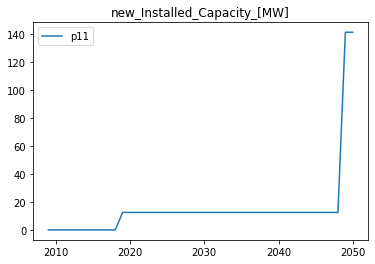

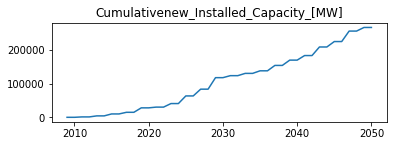

In [43]:
keyword='new_Installed_Capacity_[MW]'
foo = r1.scenario[PCAs[0]].data[keyword].copy()
plt.figure()
plt.plot(r1.scenario[PCAs[0]].data['year'], foo, label=PCAs[12])
plt.title(keyword)
plt.legend()

for jj in range (1, len(PCAs)): 
    foo += r1.scenario[PCAs[jj]].data[keyword]
     
fig = plt.figure()
ax = fig.add_subplot(2, 1, 1)
ax.plot(r1.scenario[PCAs[0]].data['year'], foo, label='US')
plt.title("Cumulative" +keyword)
#ax.set_yscale('log')
print(max(foo))


In [ ]:
df.to_csv(r'Path where you want to store the exported CSV file\File Name.csv')

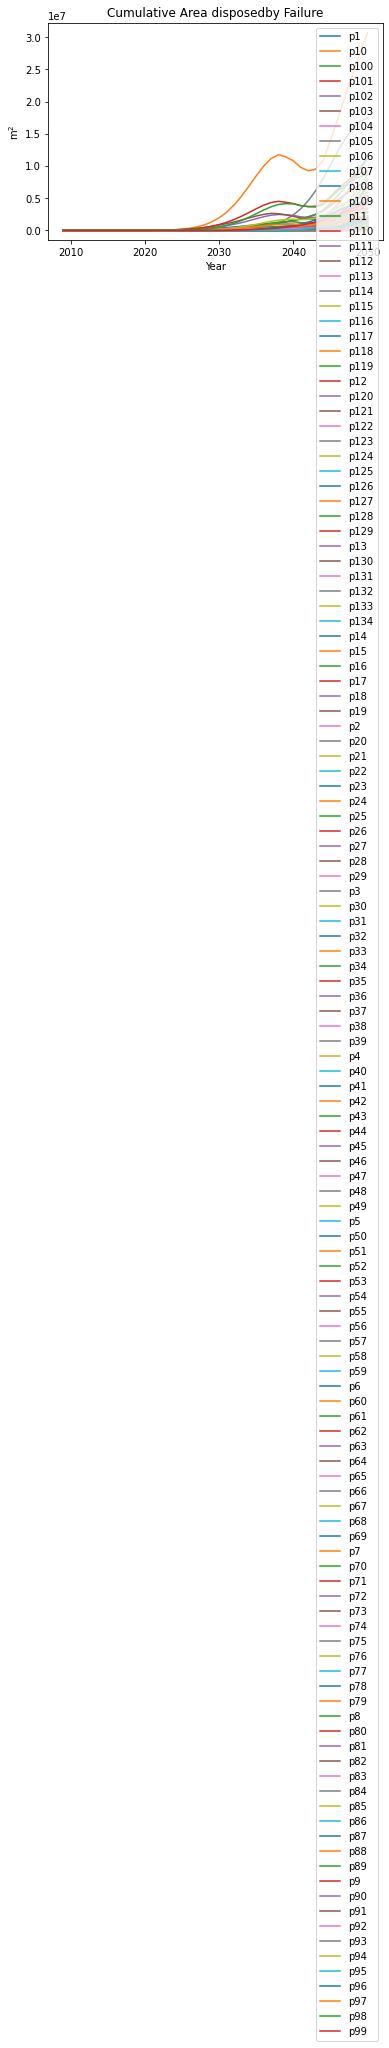

In [40]:
r1.plotScenariosComparison(keyword='Cumulative_Area_disposedby_Failure')

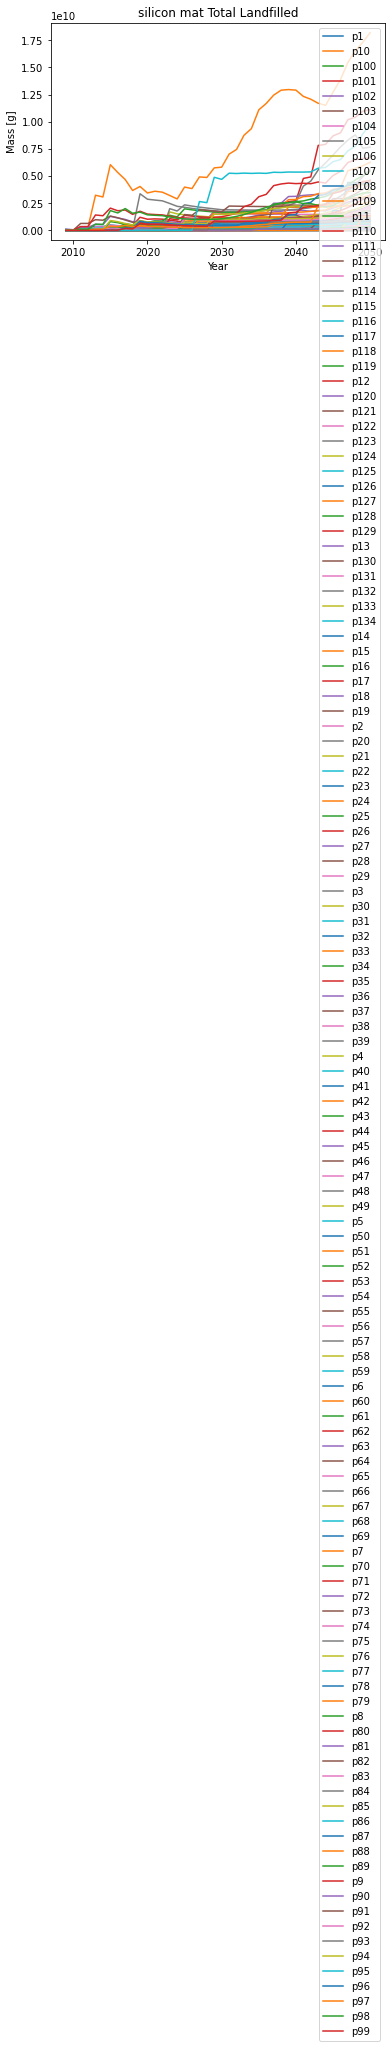

In [41]:
r1.plotMaterialComparisonAcrossScenarios(material='silicon', keyword='mat_Total_Landfilled')

silver


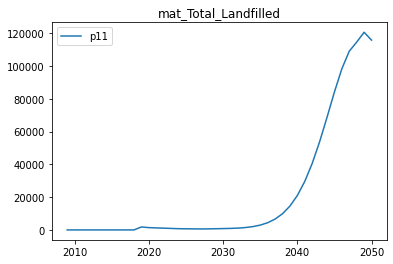

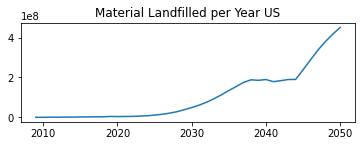

In [61]:
keyword='mat_Total_Landfilled'
plt.figure()
plt.plot(r1.scenario[PCAs[0]].data['year'], foo, label=PCAs[12])
plt.title(keyword)
plt.legend()

for jj in range (1, len(PCAs)): 
    foo['silver'] += r1.scenario[PCAs[jj]].material['silver'].materialdata[keyword]


fig = plt.figure()
ax = fig.add_subplot(2, 1, 1)
ax.plot(r1.scenario[PCAs[0]].data['year'], foo['silver'], label='US')
plt.title("Material Landfilled per Year US")
#ax.set_yscale('log')
print(max(foo))

In [60]:
foo = r1.scenario[PCAs[0]].material['silver'].materialdata[keyword].copy()
foo = r1.scenario[PCAs[0]].material['silver'].materialdata[keyword].copy()
foo = foo.to_frame(name='silver')
UScum=pd.DataFrame()
UScum['silver'] = foo['silver']

## Adding Material Landfilled for the US 

In [90]:
keyword='mat_Total_Landfilled'
materials = ['glass', 'silicon', 'silver', 'copper', 'aluminum']

USyearly=pd.DataFrame()


for ii in range (0, len(materials)):    
    material = materials[ii]
    foo = r1.scenario[PCAs[0]].material[material].materialdata[keyword].copy()
    foo = r1.scenario[PCAs[0]].material[material].materialdata[keyword].copy()
    foo = foo.to_frame(name=material)
    USyearly[material] = foo[material]

    for jj in range (1, len(PCAs)): 
        USyearly[material] += r1.scenario[PCAs[jj]].material[material].materialdata[keyword]

USyearly = USyearly/907185
USyearly.head()


,glass,silicon,silver,copper,aluminum
0,1109.544820,569.294682,0.148956,0.009245,0.000000
1,1019.943768,259.469009,0.069653,0.009000,0.000003
2,12332.319584,3096.579613,0.701834,0.108826,0.000174
3,11869.893686,3105.203000,0.540526,0.104770,0.002039
4,38064.554523,9840.060358,1.262632,0.349589,0.013726


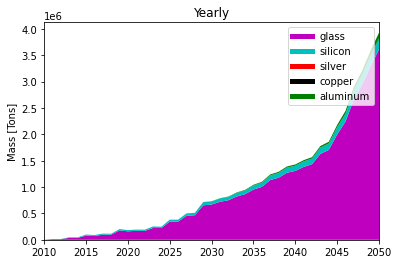

In [91]:
plt.plot([],[],color='m', label='glass', linewidth=5)
plt.plot([],[],color='c', label='silicon', linewidth=5)
plt.plot([],[],color='r', label='silver', linewidth=5)
plt.plot([],[],color='k', label='copper', linewidth=5)
plt.plot([],[],color='g', label='aluminum', linewidth=5)

plt.stackplot(r1.scenario[PCAs[0]].data['year'], USyearly['glass'], USyearly['silicon'], USyearly['silver'], USyearly['copper'], USyearly['aluminum'], colors=['m','c','r','k', 'g'])
plt.ylabel('Mass [Tons]')
plt.xlim([2010, 2050])
plt.title('Yearly')
plt.legend(materials)


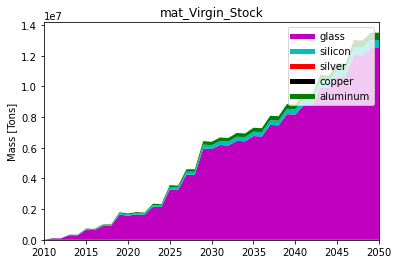

In [112]:
keyword='mat_Virgin_Stock'
materials = ['glass', 'silicon', 'silver', 'copper', 'aluminum']

USyearly=pd.DataFrame()


for ii in range (0, len(materials)):    
    material = materials[ii]
    foo = r1.scenario[PCAs[0]].material[material].materialdata[keyword].copy()
    foo = r1.scenario[PCAs[0]].material[material].materialdata[keyword].copy()
    foo = foo.to_frame(name=material)
    USyearly[material] = foo[material]

    for jj in range (1, len(PCAs)): 
        USyearly[material] += r1.scenario[PCAs[jj]].material[material].materialdata[keyword]

USyearly = USyearly/907185
USyearly.head()


plt.plot([],[],color='m', label='glass', linewidth=5)
plt.plot([],[],color='c', label='silicon', linewidth=5)
plt.plot([],[],color='r', label='silver', linewidth=5)
plt.plot([],[],color='k', label='copper', linewidth=5)
plt.plot([],[],color='g', label='aluminum', linewidth=5)

plt.stackplot(r1.scenario[PCAs[0]].data['year'], USyearly['glass'], USyearly['silicon'], USyearly['silver'], USyearly['copper'], USyearly['aluminum'], colors=['m','c','r','k', 'g'])
plt.ylabel('Mass [Tons]')
plt.xlim([2010, 2050])
plt.title(keyword)
plt.legend(materials)



## Calculating Cumulative Yearly Waste for US

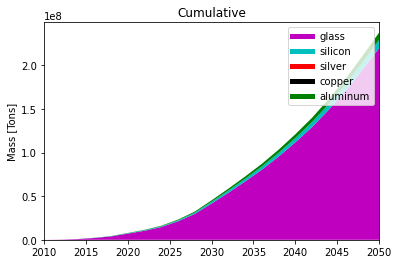

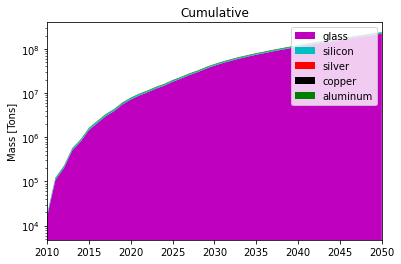

In [114]:
UScum = USyearly.copy()
UScum = UScum.cumsum()
UScum.head()

    
plt.plot([],[],color='m', label='glass', linewidth=5)
plt.plot([],[],color='c', label='silicon', linewidth=5)
plt.plot([],[],color='r', label='silver', linewidth=5)
plt.plot([],[],color='k', label='copper', linewidth=5)
plt.plot([],[],color='g', label='aluminum', linewidth=5)

plt.stackplot(r1.scenario[PCAs[0]].data['year'], UScum['glass'], UScum['silicon'], UScum['silver'], UScum['copper'], UScum['aluminum'], colors=['m','c','r','k', 'g'])
plt.ylabel('Mass [Tons]')
plt.xlim([2010, 2050])
plt.title('Cumulative')
plt.legend(materials)

plt.figure()
plt.stackplot(r1.scenario[PCAs[0]].data['year'], UScum['glass'], UScum['silicon'], UScum['silver'], UScum['copper'], UScum['aluminum'], colors=['m','c','r','k', 'g'])
plt.ylabel('Mass [Tons]')
plt.title('Cumulative')
plt.xlim([2010, 2050])
plt.yscale('log')
plt.legend(materials)

## Non stacked plot, previuos method

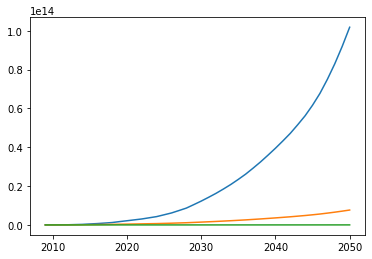

In [100]:
''' 
material1='glass'
material2='silicon'
material3='silver'
keyword='mat_Total_Landfilled'

USlandfill_glass = r1.scenario[PCAs[0]].material[material1].materialdata[keyword]
USlandfill_silicon = r1.scenario[PCAs[0]].material[material2].materialdata[keyword]
USlandfill_silver = r1.scenario[PCAs[0]].material[material3].materialdata[keyword]

for jj in range (1, len(PCAs)): 
    USlandfill_glass += r1.scenario[PCAs[jj]].material[material1].materialdata[keyword] 
    USlandfill_silicon += r1.scenario[PCAs[jj]].material[material2].materialdata[keyword] 
    USlandfill_silver += r1.scenario[PCAs[jj]].material[material3].materialdata[keyword]
    
UScumsumlandfill_glass = np.cumsum(USlandfill_glass)
UScumsumlandfill_silicon = np.cumsum(USlandfill_silicon)
UScumsumlandfill_silver = np.cumsum(USlandfill_silver)


plt.plot(r1.scenario[PCAs[0]].data['year'], UScumsumlandfill_glass, label='Glass')
plt.plot(r1.scenario[PCAs[0]].data['year'], UScumsumlandfill_silicon, label='Silicon')
plt.plot(r1.scenario[PCAs[0]].data['year'], UScumsumlandfill_silver, label='Silver')
'''

# GEOPANDAS

In [101]:
latitude_all =[]
longitude_all = []
cumulativewaste2050 = []
for scen in r1.scenario.keys():
    latitude_all.append(r1.scenario[scen].latitude)
    longitude_all.append(r1.scenario[scen].longitude)
    cumulativewaste2050.append(r1.scenario[scen].material['glass'].materialdata['mat_Total_Landfilled'].sum())

In [102]:
import pandas as pd
import matplotlib.pyplot as plt
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon

street_map = gpd.read_file(r'C:\Users\sayala\Desktop\geopandas\cb_2018_us_nation_20m\cb_2018_us_nation_20m.shp')

# Show the map only
#fig, ax = plt.subplots(figsize=(10,15))
#street_map.plot(ax=ax)

In [103]:
frame = { 'Latitude': latitude_all, 'Longitude': longitude_all, 'CumulativeWaste2050': cumulativewaste2050}   
df = pd.DataFrame(frame) 

In [104]:
df.head()

,Latitude,Longitude,CumulativeWaste2050
0,47.820991,-121.452252,1.018143e+14
1,35.120104,-117.159039,4.453101e+12
2,38.791108,-78.257714,3.007049e+09
3,28.708695,-82.192477,1.526966e+12
4,26.677092,-80.563731,8.485484e+11


In [105]:
geometry = [Point(xy) for xy in zip(df['Longitude'], df['Latitude'])]
geometry[:3]

In [106]:
crs = {'init':'epsg:4326'}

In [107]:
geo_df = gpd.GeoDataFrame(df, # specify our data
                         crs = crs, # specify our coordinate reference system
                         geometry = geometry) # specify the geometry list we created
geo_df.head()

,Latitude,Longitude,CumulativeWaste2050,geometry
0,47.820991,-121.452252,1.018143e+14,POINT (-121.45225 47.82099)
1,35.120104,-117.159039,4.453101e+12,POINT (-117.15904 35.12010)
2,38.791108,-78.257714,3.007049e+09,POINT (-78.25771 38.79111)
3,28.708695,-82.192477,1.526966e+12,POINT (-82.19248 28.70870)
4,26.677092,-80.563731,8.485484e+11,POINT (-80.56373 26.67709)


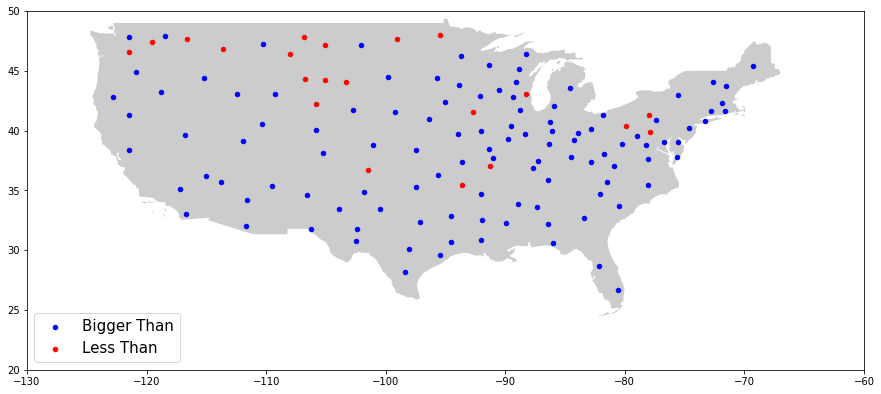

In [108]:
fig, ax = plt.subplots(figsize = (15,15))
street_map.plot(ax = ax, alpha = 0.4, color = "grey")
geo_df[geo_df['CumulativeWaste2050'] >= 1.918125e+09].plot(ax=ax, markersize = 20, color= "blue", marker = "o", label = "Bigger Than")
geo_df[geo_df['CumulativeWaste2050'] < 1.918125e+09].plot(ax=ax, markersize = 20, color= "red", marker = "o", label = "Less Than")
plt.xlim([-130, -60])
plt.ylim([20, 50])
plt.legend(prop={'size':15})

In [ ]:
import random
import pandas as pd
import matplotlib.pyplot as plt
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon

latitude = random.sample(range(25, 45), 10) 
longitude = random.sample(range(-125, -65), 10) 
weight = random.sample(range(0, 500), 10) 

frame = { 'Latitude': latitude, 'Longitude': longitude, 'Weight': weight}   
df = pd.DataFrame(frame) 

geometry = [Point(xy) for xy in zip(df['Longitude'], df['Latitude'])]
crs = {'init':'epsg:4326'}
geo_df = gpd.GeoDataFrame(df, # specify our data
                         crs = crs, # specify our coordinate reference system
                         geometry = geometry) # specify the geometry list we created

fig, ax = plt.subplots(figsize = (15,15))
street_map.plot(ax = ax, alpha = 0.4, color = "grey")
geo_df[geo_df['Weight'] >=250].plot(ax=ax, markersize = 20, color= "blue", marker = "o", label = "Bigger Than")
geo_df[geo_df['Weight'] < 250].plot(ax=ax, markersize = 20, color= "red", marker = "o", label = "Less Than")
plt.xlim([-130, -60])
plt.ylim([20, 50])
plt.legend(prop={'size':15})

In [ ]:
import geoplot


In [ ]:
ax = street_map.kdeplot(
    geo_df, #clip=boroughs.geometry,
    shade=True, cmap='Reds',
    projection=geoplot.crs.AlbersEqualArea())
geoplot.polyplot(boroughs, ax=ax, zorder=1)

In [ ]:
import scipy.stats
import seaborn.palettes
import seaborn.utils


In [ ]:
axis = [-130, 48.1667, -70, 100.1667]

In [ ]:
latlng_bounds = area.total_bounds
area = area.to_crs(epsg=3857)
axis = area.total_bounds

# Create the map stretching over the requested area
ax = area.plot(alpha=0)

In [ ]:
# Calculate the KDE
data = np.c_[df.Longitude, df.Latitude]
kde = scipy.stats.gaussian_kde(data.T, bw_method="scott", weights=df.CumulativeWaste2050)
data_std = data.std(axis=0, ddof=1)
bw_x = getattr(kde, "scotts_factor")() * data_std[0]
bw_y = getattr(kde, "scotts_factor")() * data_std[1]
grid_x = grid_y = 100
x_support = seaborn.utils._kde_support(data[:, 0], bw_x, grid_x, 3, (axis[0], axis[2]))
y_support = seaborn.utils._kde_support(data[:, 1], bw_y, grid_y, 3, (axis[1], axis[3]))
xx, yy = np.meshgrid(x_support, y_support)
levels = kde([xx.ravel(), yy.ravel()]).reshape(xx.shape)

In [ ]:
cset = ax.contourf(xx, yy, levels,
    20, # n_levels

    cmap=seaborn.palettes.blend_palette(('#ffffff10', '#ff0000af'), 6, as_cmap=True),
    antialiased=True,       # avoids lines on the contours to some extent
)

In [ ]:
def add_basemap(ax, latlng_bounds, axis, url='https://a.basemaps.cartocdn.com/light_all/tileZ/tileX/tileY@2x.png'):
    prev_ax = ax.axis()
    # TODO: Zoom should surely take output pixel request size into account...
    zoom = ctx.tile._calculate_zoom(*latlng_bounds)
    while ctx.tile.howmany(*latlng_bounds, zoom, ll=True) > max_tiles:      # dont ever try to download loads of tiles
        zoom = zoom - 1
    print("downloading %d tiles with zoom level %d" % (ctx.tile.howmany(*latlng_bounds, zoom, ll=True), zoom))
    basemap, extent = ctx.bounds2img(*axis, zoom=zoom, url=url)
    ax.imshow(basemap, extent=extent, interpolation='bilinear')
    ax.axis(prev_ax)        # restore axis after changing the background
 
add_basemap(ax, latlng_bounds, axis)

In [ ]:
import geopandas as gpd


import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np

def make_plot(projection_name, projection_crs, extent, heat_data):
    """
    ?
    """
    fig = plt.figure()
    rect = 0.1, 0.1, 0.8, 0.8
    ax = fig.add_axes(rect, projection=projection_crs)

    # Set display limits to include a set region of latitude * longitude.
    # (Note: Cartopy-specific).
    ax.set_extent(extent, crs=projection_crs)

    # Add coastlines and meridians/parallels (Cartopy-specific).
    ax.coastlines(linewidth=0.2, color='black')
    ax.gridlines(crs=projection_crs, linestyle='-')

    lat = np.linspace(extent[0],extent[1],heat_data.shape[0])
    lon = np.linspace(extent[2],extent[3],heat_data.shape[1])
    Lat,Lon = np.meshgrid(lat,lon)
    ax.pcolormesh(Lat,Lon,np.transpose(heat_data))
    plt.savefig("Test_fig.pdf", bbox_inches='tight')


def main():
    #extent = (-65.0, -62, 44, 45.5)
    extent = (-90, -40, 30, 60)
    # Define some test points with latitude and longitude coordinates.
    #city_data = [('Halifax, NS', 44.67, -63.61, 'black'),
    #             ('Neighbour', 45, -63, 'blue'),
    #             ('Other_Place', 44.1, -64, 'red')]
    heat_data = np.random.normal(0.0,0.2,size=(100,150))

    # Demonstrate with two different display projections.
    # Define a Cartopy 'ordinary' lat-lon coordinate reference system.
    crs_latlon = ccrs.PlateCarree()
    make_plot('Equidistant Cylindrical', crs_latlon, extent, heat_data)
    #crs_ae = ccrs.LambertCylindrical()
    #make_plot('Lambert Cylindrical', crs_ae, extent, heat_data)

if __name__ == '__main__':
    main()